In [1]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

plt.rcParams["figure.figsize"] = (10,10)

In [2]:
# Original dataframe
attrs = ["letter", "x-box", "y-box", "width", "high", "onpix", "x-bar",
         "y-bar", "x2bar", "y2bar", "xybar", "x2ybr", "xy2br", "x-ege",
         "xegvy", "y-ege", "yegvx"]
df = pd.read_csv("data/letter-recognition.data", names=attrs)
df.head()

,letter,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [3]:
# data split
X, Y = df.iloc[:, 1:], df.iloc[:, 0]
#X = StandardScaler().fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    train_size = 0.8, 
                                                    random_state = 8,
                                                    shuffle = True,
                                                    stratify = Y)

In [4]:
Ks = np.arange(1, 57, 2)
# Time elapsed of fitting KNN with each number of principal component
performance = []
# Contains the k-value and the weight scheme of each best KNN
best_knns = []
# Train and test accuracy
accuracy = []

for i in range(2, 15):
    print("Start session", i)
    
    # PCA
    pca_ = PCA(n_components=i).fit(X_train)
    pca_result_ = pca_.transform(X_train)
    pca_test_ = pca_.transform(X_test)
    
    # Find best KNN
    pipe_ = Pipeline([('knn', KNeighborsClassifier())])
    search_space_ = [
        {'knn': [KNeighborsClassifier()],
         'knn__weights': ['uniform', 'distance'],
         'knn__n_neighbors': Ks
        }
    ]
    search_ = GridSearchCV(pipe_,
                           search_space_,
                           scoring = 'accuracy',
                           n_jobs = -1,
                           refit=False,
                           cv = StratifiedKFold(n_splits=5),
                           verbose = 0)
    
    start_ = time.time()
    best_knn_ = search_.fit(pca_result_, Y_train)
    end_ = time.time()
    
    best_knn_info_ = best_knn_.cv_results_['params'][np.argmin(best_knn_.cv_results_['rank_test_score'])]
    best_k_ = best_knn_info_["knn__n_neighbors"]
    best_weights_ = best_knn_info_["knn__weights"]
    
    # Fit with best KNN
    knn_ = KNeighborsClassifier(weights = best_knn_info_.get('knn__weights'),
                                n_neighbors = best_knn_info_.get('knn__n_neighbors'))
    knn_.fit(pca_result_, Y_train)
    train_acc_ = accuracy_score(Y_train, knn_.predict(pca_result_))
    test_acc_ = accuracy_score(Y_test, knn_.predict(pca_test_))
    
    best_knns.append([best_k_])
    best_knns[-1].append(best_weights_)
    performance.append(end_ - start_)
    accuracy.append([train_acc_])
    accuracy[-1].append(test_acc_)

Start session 2
Start session 3
Start session 4
Start session 5
Start session 6
Start session 7
Start session 8
Start session 9
Start session 10
Start session 11
Start session 12
Start session 13
Start session 14


In [5]:
performance

[7.725999355316162,
 4.836996793746948,
 5.715001106262207,
 6.9910359382629395,
 9.337000131607056,
 12.285945177078247,
 16.03599715232849,
 17.973002433776855,
 21.18831157684326,
 26.871999740600586,
 27.35100030899048,
 29.961186170578003,
 34.157997846603394]

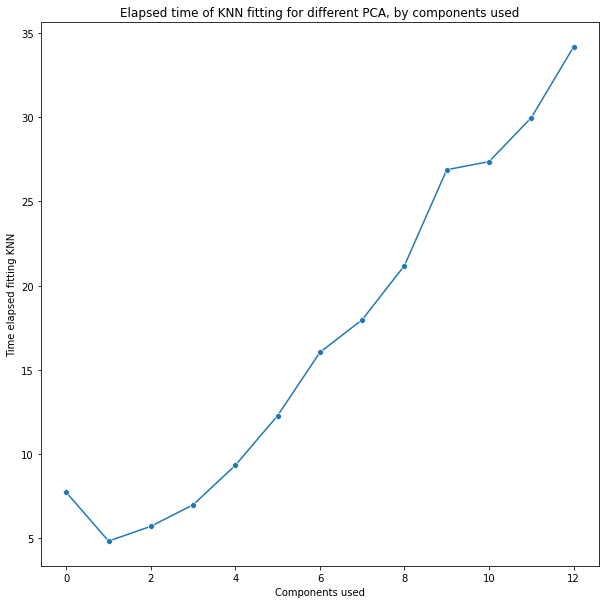

In [6]:
sns.lineplot(data=performance, marker="o")
plt.title("Elapsed time of KNN fitting for different PCA, by components used")
plt.xlabel("Components used")
plt.ylabel("Time elapsed fitting KNN")
plt.show()

In [7]:
best_knns

[[55, 'distance'],
 [49, 'distance'],
 [11, 'distance'],
 [9, 'distance'],
 [5, 'distance'],
 [5, 'distance'],
 [5, 'distance'],
 [3, 'distance'],
 [3, 'distance'],
 [3, 'distance'],
 [3, 'distance'],
 [1, 'uniform'],
 [5, 'distance']]

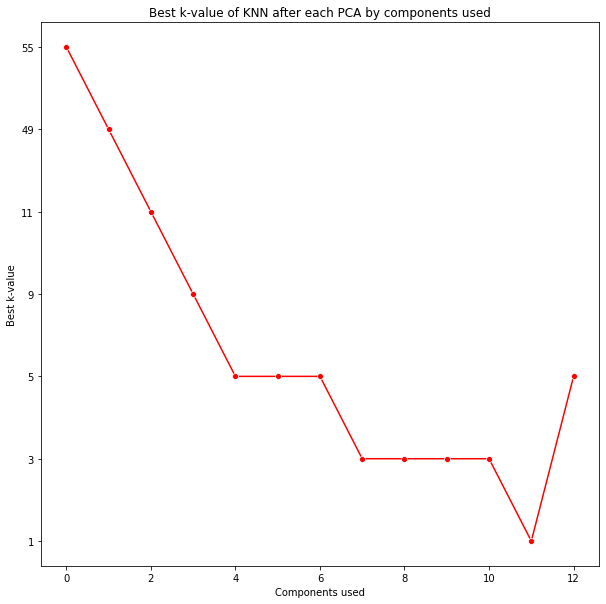

In [8]:
sns.lineplot(data=np.array(best_knns)[:,0], color="r", marker="o")
plt.title("Best k-value of KNN after each PCA by components used")
plt.xlabel("Components used")
plt.ylabel("Best k-value")
plt.show()

In [9]:
accuracy

[[1.0, 0.25825],
 [1.0, 0.45125],
 [1.0, 0.6395],
 [1.0, 0.74125],
 [1.0, 0.8325],
 [1.0, 0.877],
 [1.0, 0.89875],
 [1.0, 0.9225],
 [1.0, 0.93325],
 [1.0, 0.9395],
 [1.0, 0.9485],
 [1.0, 0.95575],
 [1.0, 0.95575]]

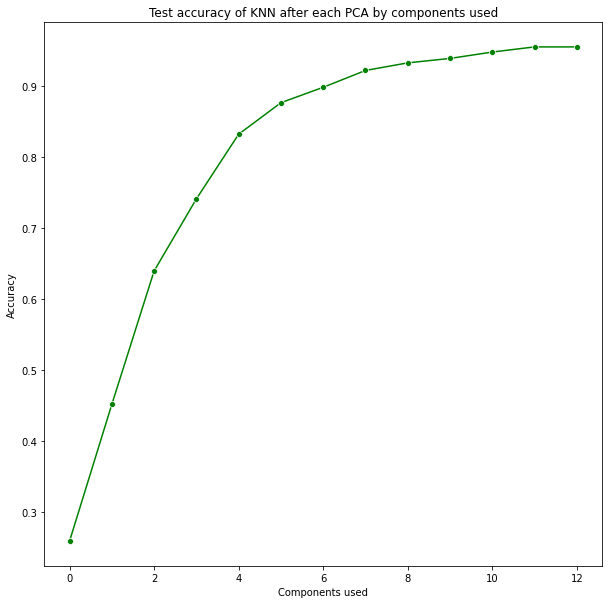

In [10]:
sns.lineplot(data=np.array(accuracy)[:,1], color="g", marker="o")
plt.title("Test accuracy of KNN after each PCA by components used")
plt.xlabel("Components used")
plt.ylabel("Accuracy")
plt.show()